## Load dataset

In [23]:
import os
import pandas as pd
import torch
from torch.utils import data
from d2l import torch as d2l
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt

import torch



In [24]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [25]:
df, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(df) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(df.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [26]:
num_users = len(df['user_id'].unique())
num_items = len(df['item_id'].unique())

num_users, num_items

(943, 1682)

In [27]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
d = defaultdict(LabelEncoder)
cols_cat = ['user_id', 'item_id']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
df.head(3)

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116


In [28]:
df = df[['user_id', 'item_id', 'rating']]

In [29]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.3):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in torch.rand(
            (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data.reset_index(), test_data.reset_index()

In [30]:
train, test = split_data_ml100k(df, num_users, num_items, test_ratio=0.3)
val, test = split_data_ml100k(test, num_users, num_items, test_ratio=0.5)

In [31]:
train, test, val

(       index  user_id  item_id  rating
 0          0      195      241       3
 1          1      185      301       3
 2          3      243       50       2
 3          4      165      345       1
 4          5      297      473       4
 ...      ...      ...      ...     ...
 70070  99994      377       77       3
 70071  99995      879      475       3
 70072  99997      275     1089       1
 70073  99998       12      224       2
 70074  99999       11      202       3
 
 [70075 rows x 4 columns],
        level_0  index  user_id  item_id  rating
 0            0      2       21      376       1
 1            1      6      114      264       2
 2            3     14      223       28       3
 3            5     19      233     1183       2
 4            6     21      166      485       4
 ...        ...    ...      ...      ...     ...
 14989    29920  99984      653      369       2
 14990    29921  99985      616      581       4
 14991    29922  99988      420      497       4
 

In [32]:
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.users = df['user_id']
        self.items = df['item_id']
        self.ratings = df['rating']
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        user = self.users[index]
        item = self.items[index]
        rating = self.ratings[index]
        
        return user, item, rating


train_dataset = MovieDataset(train)
val_dataset = MovieDataset(val)
test_dataset = MovieDataset(test)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=False)

In [33]:
len(train_dataloader), len(test_dataloader)

(137, 30)

In [34]:
train.to_csv('train_split.csv')
test.to_csv('test_split.csv')
val.to_csv('val_split.csv')

## Initialize model

In [35]:
num_factors = 50 # embedding dimension

In [36]:
from models import MatrixFactorization

model = MatrixFactorization(num_factors, num_users, num_items)

## Train model

In [37]:
lr = 0.001
num_epochs = 30
device = 'cpu'

opt = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

train_losses = []
val_losses = []

for i in range(num_epochs):
    epoch_train_losses = []
    epoch_val_losses = []
    
    model.train()
    
    for user_batch, item_batch, rating_batch in train_dataloader:
        user_batch = user_batch.to(device, dtype=torch.long)
        item_batch = item_batch.to(device, dtype=torch.long)
        rating_batch = rating_batch.to(device, dtype=torch.float)
        
        preds = model(user_batch, item_batch)
        loss = criterion(preds, rating_batch)
        epoch_train_losses.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    model.eval()
    for user_batch, item_batch, rating_batch in val_dataloader:
        user_batch = user_batch.to(device, dtype=torch.long)
        item_batch = item_batch.to(device, dtype=torch.long)
        rating_batch = rating_batch.to(device, dtype=torch.float)
        
        preds = model(user_batch, item_batch)
        loss = criterion(preds, rating_batch)
        epoch_val_losses.append(loss.item())
        
    mean_epoch_train_loss = np.mean(epoch_train_losses)
    mean_epoch_val_loss = np.mean(epoch_val_losses)
    train_losses.append(mean_epoch_train_loss)
    val_losses.append(mean_epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {mean_epoch_train_loss}, Val Loss:{mean_epoch_val_loss}')

Epoch: 0, Train Loss: 12.931937572729849, Val Loss:11.288398806254069
Epoch: 1, Train Loss: 7.063789317207615, Val Loss:3.3209660132726033
Epoch: 2, Train Loss: 2.022379928261694, Val Loss:1.4470152060190837
Epoch: 3, Train Loss: 1.212782606156203, Val Loss:1.134235833088557
Epoch: 4, Train Loss: 1.0153067708015442, Val Loss:1.0217368125915527
Epoch: 5, Train Loss: 0.9356102286464106, Val Loss:0.9696782092253368
Epoch: 6, Train Loss: 0.8954136837137877, Val Loss:0.9437033176422119
Epoch: 7, Train Loss: 0.8718019945778116, Val Loss:0.9275424142678579
Epoch: 8, Train Loss: 0.8555955490926757, Val Loss:0.9173378805319469
Epoch: 9, Train Loss: 0.8435411662080862, Val Loss:0.9097111721833547
Epoch: 10, Train Loss: 0.8329601235633349, Val Loss:0.9038682738939922
Epoch: 11, Train Loss: 0.8246472525770647, Val Loss:0.898532259464264
Epoch: 12, Train Loss: 0.8157871391651405, Val Loss:0.8947099268436431
Epoch: 13, Train Loss: 0.8080638264217516, Val Loss:0.8897179822127025
Epoch: 14, Train Loss

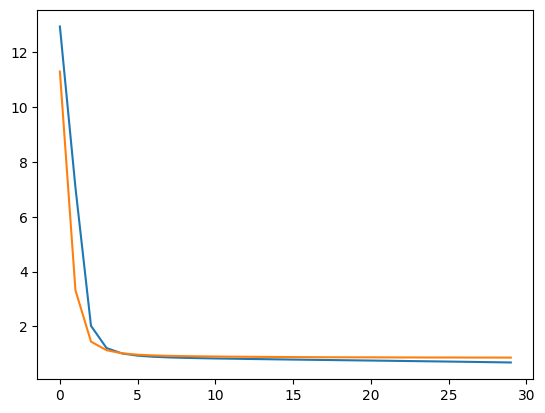

In [38]:
plt.plot(train_losses)
plt.plot(val_losses)

In [58]:
user_emb_min_w = model.user_embedding.weight.min().item()
user_emb_max_w = model.user_embedding.weight.max().item()
item_emb_min_w = model.item_embedding.weight.min().item()
item_emb_max_w = model.item_embedding.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {rating_batch.min().item():0.2f} / {rating_batch.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(rating_batch.detach().cpu().numpy()[:6])

Emb user min/max w: -1.738 / 1.641
Emb item min/max w: -1.270 / 1.029
Preds min/max: 1.98 / 4.93
Rating min/max: 1.00 / 5.00
[3.686532  3.4011168 2.3401518 3.650963  4.3504868 4.506187 ]
[4. 3. 3. 4. 5. 1.]


In [59]:
model.user_embedding.weight.shape

torch.Size([943, 50])

In [60]:
model.item_embedding.weight.shape

torch.Size([1682, 50])

In [61]:
matrix = model.user_embedding.weight @ model.item_embedding.weight.T

In [81]:
matrix = matrix.detach().numpy()

In [82]:
actual = np.zeros(matrix.shape)

In [83]:
df

,user_id,item_id,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1
...,...,...,...
99995,879,475,3
99996,715,203,5
99997,275,1089,1
99998,12,224,2


In [84]:
for i, row in df.iterrows():
    actual[row.user_id][row.item_id] = row.rating

In [85]:
actual.shape

(943, 1682)

In [86]:
exclude = pd.concat((train['user_id item_id rating'.split()], val['user_id item_id rating'.split()]))

In [87]:
exclude

,user_id,item_id,rating
0,195,241,3
1,185,301,3
2,243,50,2
3,165,345,1
4,297,473,4
...,...,...,...
14926,888,1,3
14927,393,379,4
14928,935,286,4
14929,720,873,3


In [88]:
exclude_matrix = np.zeros(matrix.shape)

for i, row in exclude.iterrows():
    exclude_matrix[row.user_id][row.item_id] = -1

In [89]:
exclude_matrix

array([[-1., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.]])

In [90]:
matrix * exclude_matrix

array([[-3.60912776, -2.93024087, -2.90034127, ...,  0.        ,
         0.        ,  0.        ],
       [-3.68500304,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.        ,  0.        ],
       ...,
       [-4.19610214,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -3.24110556,  0.        , ...,  0.        ,
        -0.        ,  0.        ]])

In [91]:
test

,level_0,index,user_id,item_id,rating
0,0,2,21,376,1
1,1,6,114,264,2
2,3,14,223,28,3
3,5,19,233,1183,2
4,6,21,166,485,4
...,...,...,...,...,...
14989,29920,99984,653,369,2
14990,29921,99985,616,581,4
14991,29922,99988,420,497,4
14992,29923,99993,912,208,2


In [94]:
np.argsort(exclude_matrix[21])

array([1001,   88,  997, ...,  599,  597, 1681])

In [95]:
np.argsort(actual[21])

array([   0, 1132, 1131, ...,  193,  207,  249])

In [96]:
test

,level_0,index,user_id,item_id,rating
0,0,2,21,376,1
1,1,6,114,264,2
2,3,14,223,28,3
3,5,19,233,1183,2
4,6,21,166,485,4
...,...,...,...,...,...
14989,29920,99984,653,369,2
14990,29921,99985,616,581,4
14991,29922,99988,420,497,4
14992,29923,99993,912,208,2


In [101]:
test_preds = []

for i, row in test.iterrows():
    test_preds.append(model(torch.tensor(row.user_id), 
                            torch.tensor(row.item_id)).item())

In [102]:
test_preds

[1.8367598056793213,
 3.527670383453369,
 2.8516688346862793,
 1.9011503458023071,
 3.6373939514160156,
 3.0274829864501953,
 3.934994697570801,
 4.248363018035889,
 4.446523189544678,
 4.504467487335205,
 3.1485157012939453,
 3.8281760215759277,
 3.497807264328003,
 4.171473979949951,
 4.172181129455566,
 4.505391597747803,
 3.9902100563049316,
 2.6252875328063965,
 3.393479347229004,
 3.591369867324829,
 3.5334713459014893,
 2.2698097229003906,
 4.069159984588623,
 2.933664560317993,
 3.333639144897461,
 3.9225778579711914,
 4.691843509674072,
 3.193721294403076,
 3.207199811935425,
 3.752953052520752,
 3.682608127593994,
 3.7217154502868652,
 4.23317289352417,
 2.7684695720672607,
 3.6770315170288086,
 3.6145801544189453,
 3.3610587120056152,
 2.988036632537842,
 3.845590829849243,
 4.740993499755859,
 3.653045892715454,
 4.238592147827148,
 2.7558329105377197,
 3.1672840118408203,
 3.393627405166626,
 3.9898853302001953,
 3.426269292831421,
 2.2477378845214844,
 3.358656883239746,


In [131]:
qrels = pd.DataFrame()
qrels['qid'] = test['user_id'].values
qrels['iter'] = [0 for _ in range(len(test))]
qrels['docno'] = test['item_id'].values
qrels['rel']= [1 if i >= 4.0 else 0 for i in test['rating'].values]
# qrels['rel'] = test['rating'].values
qrels.to_csv('qrels', sep=' ', header=False, index=False)

In [132]:
run = pd.DataFrame()
run['qid'] = test['user_id'].values
run['iter'] = [-1 for _ in range(len(test))]
run['docno'] = test['item_id'].values
run['rank'] = [-1 for _ in range(len(test))]
run['sim'] = [float(i) for i in test_preds]
run['run_id'] = [-1 for _ in range(len(test))]
run.to_csv('run', sep=' ', header=False, index=False)